# **Chap7：自然语言处理**

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from source.code import ch7
from source.code import utils 
import os
import time

2023-06-15 17:36:46.018457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 17:36:46.197041: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-15 17:36:46.230326: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-15 17:36:47.181777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=2)

## **7.5 BERT微调应用**

在上一节中，我们为了单文本，多文本任务设计了各种模型架构，以完成不同的 NLP 任务
* 但 NLP 任务千变万化，**针对每一种任务设计对应的模型是不现实的**
* BERT 的出现使得我们能够**仅做出最微小的下游任务调整**，就能够**解决几乎所有 NLP 任务**，这就是 BERT 的优势所在

### **7.5.1 各种 NLP 任务下微调 BERT**

各种 NLP 任务可以分为两大类：**词元级任务**和**序列级任务**：
* **词元级**：需要针对文本序列中的每一个词元做出判断，例如**词性标注**，**命名主体识别**，**标记子序列的开始和结束**等
* **序列级**：对完整的整条序列做出预测和判断，例如**文本分类**，**文本相似性匹配**，**自然语言推断**等

借助 **BERT 特殊序列输入格式（可以同时输入文本对）**，下面我们介绍四种 NLP 任务的 BERT 微调方案，以展示 BERT 架构的灵活和强大

**(1) 单文本分类**

单文本分类将单个文本序列作为输入，并要求预测文本类别，借助 BERT 的**特殊词元** `<cls>` 和**自注意力机制**，可以直接将 `<cls>` 的编码表示作为下游分类器模型的输入特征使用，我们可以**认为** `<cls>` **抽取了整个序列的信息**，结构如下图所示：

<img src="./source/Chap7/bert单文本分类.svg" width=600>

**(2) 文本对分类或回归**

文本对接收两条文本序列，并判断它们的**逻辑关系（分类任务，例如自然语言推断）**或**相似性**（**回归任务**），由于 BERT 天生支持文本对输入：`<cls> tokens_a <sep> tokens_b <sep>`，与单文本任务类似，我们**依然可以使用** `<cls>` **的编码表示作为下游任务的输入特征**，因为通过自注意力，它可以蕴含整个序列的信息
* 需要注意，如果下游任务是回归任务，则需要修改损失函数，而不是继续使用交叉熵损失

<img src="./source/Chap7/bert文本对任务.svg" width=600>

**(3) 词元级任务：文本标注**

词元级任务中，我们需要对每个词元的属性做出预测，例如**文本标注**（例如标定每个单词是形容词、介词、名词还是动词等），我们可以**直接将 BERT 对每个词元的编码作为输入特征**，直接接入文本标注的分类器，如下图所示

<img src="./source/Chap7/bert文本标注.svg" width=600>

需要注意，这些针对**每个词元的下游分类器网络是同一个模型实例**，即不同词元的分类器**参数共享**，而不要错误地对每一个词元的分类都创建了一个模型实例

**(4) 词元级任务：问答**

问答的任务模式是，给定两段文本序列**问题**和**文章**，问答的**标签是从文章中找出能回答问题的子序列**（即**预测答案在文章中的开始位置和结束位置**），例如：
* **问题**：谁喜欢吃饼干？
* **文章**：Bob 喜欢饼干，而 Mike 喜欢吃糖
* **回答**：Bob（出现在文章的开头，**标签会标注答案的开始和结束位置**）

因此，我们可以将 BERT 输入序列中的 `tokens_a` 设置为问题，将 `tokens_b` 设置为**文章**，然后将**文章的每个词元的 BERT 编码作为下游分类器的输入**
* 分类器需要创建两个：**开始位置分类器**和**结束位置分类器**
* 分类器预测文章 `tokens_b` 中**每个词元** $w_i$ **作为开始和结束词元的概率** $b_i, e_i$
* 在从文章中确定回答的片段时，可以选择**最大化片段分数** $b_i + e_j$，则 $w_i,w_j$ 即为回答的开始和结束词元
* 与前面的词元级任务模型一样，预测每个词元作为开始 / 结束词元的下游模型应该是同一个，保证**参数共享**

<img src="./source/Chap7/bert问答.svg" width=600>

### **7.5.2 以自然语言推断为例微调 BERT**

我们这里展示如何用**预训练过的 BERT 模型**，通过微调来完成上一节的**自然语言推断任务**，大致分为三个步骤：
* **导入预训练 BERT 模型**：包括模型本身，模型的词表 `vocab` 和分词器 `tokenizer`
* **将文本输入转换为 BERT 所需的格式**：回忆 BERT 模型需要处理特定格式的文本序列 `<cls> tokens_a <sep> tokens_b <sep>`
* **创建下游任务模型**：最后搭建下游任务模型，编写训练逻辑，开始进行微调

**(1) 导入预训练的 BERT 模型**

对于一些重要和经典的模型，**在各种平台、框架上都会有已经预训练好的模型文件**，我们这里以 `Tensorflow Hub` 平台为例，还有一些平台也可供选择，例如 `HuggingFace Transformer`，需要注意，对于一个 NLP 模型，一般**以下三个组件是配对的**，在**导入预训练模型时，请确保它们的对应关系**：
* **模型本省**：指代模型架构，以及模型中的参数
* **词表**：预训练模型时，由预训练数据集得到的词表，**在所有的推理预测和微调中，必须使用相同的词表**
* **分词器**：分词器与词表对应，由于不同模型的分词方案可能不同，需**确保按照模型预定义的分词方案来对序列做词元化处理**，这就是分词器的作用

为了导入和使用预训练模型，我们还需要安装两个额外的 Python 包：
* `tf-models-official`：这可以让我们导入 `tensorflow_models`
* `tensorflow_hub`：一般会和 `Tensorflow` 一同安装
* `tensorflow-text`：`Tensorflow` 处理文本数据的各种接口

**注意**：安装这些额外的扩展包时，最好与当前你使用的 `Tensorflow` 版本对应

In [3]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow_hub as hub

从官方提供的 BERT 路径中，我们可以**加载相应的模型和分词器**：
* **分词器路径**：`"https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"`
* **模型路径**：`“https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2"`
  * 模型文件名中 `L-2, H-128, A-2` 分别代表了模型的参数 `num_layers = 2`，`num_hiddens = 128`，`num_heads = 2`，这是 BERT 编码其中 Transformer 的模型超参数
  * 由于**微调原始的 BERT 需要耗费较大的计算力**，我们这里选择了一个**规模很小的 BERT 模型用于演示**

下面从词表文件导入分词器，创建 `bert_tokenizer`
* 需要使用接口 `hub.load` 加载文本预处理器，然后通过访问 `.tokenize` 创建分词器
* 分词器的 `__call__` 方法可以接收存放文本序列的列表或 `tf.Tensor`，然后输出分词后的词元索引

In [5]:
# 加载 BERT 预处理器，然后创建 BERT 分词器
bert_preprocessor = hub.load(handle="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_tokenizer = bert_preprocessor.tokenize

我们所导入的 BERT 采用的是前面介绍过的**字节对编码**，因此**分词的结果不是简单的按空格分词**

In [6]:
sentence = ["hello tensorflow bert models!"]
tokens = bert_tokenizer(sentence) # 调用 __call__ 方法
tokens

<tf.RaggedTensor [[[7592], [23435, 12314], [14324], [4275], [999]]]>

通过访问 `.get_special_tokens_dict()` 能够**拿到词表中的特殊词元信息**，回忆 BERT 中包含的四个特殊词元：`<cls>, <sep>, <pad>, <mask>`
* 可以看到词表大小为 30522 个词元
* `start_of_sequence_id`：这就是 BERT 中特殊次元 `<cls>` 的索引
* `end_of_segment_id`：这就是 BERT 中特殊次元 `<sep>` 的索引
* 还可以看到填充 `<pad>` 索引和掩蔽 `<mask>` 的索引

In [7]:
bert_tokenizer.get_special_tokens_dict()

{'padding_id': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'vocab_size': <tf.Tensor: shape=(), dtype=int32, numpy=30522>,
 'mask_id': <tf.Tensor: shape=(), dtype=int32, numpy=103>,
 'end_of_segment_id': <tf.Tensor: shape=(), dtype=int32, numpy=102>,
 'start_of_sequence_id': <tf.Tensor: shape=(), dtype=int32, numpy=101>}

下面的函数 `load_bert_from_pretrain()` 用于创建 BERT 模型并加载预训练参数
* 首先，我们制定要加载的 BERT 预训练模型的路径，通过 `num_layers, num_heads, num_hiddens` 控制
* **可供搭配的模型参数**可以在 [Tensorflow Hub Bert](https://tfhub.dev/google/collections/bert/1) 找到

In [8]:
def load_bert_from_pretrain(num_layers : int=2, num_heads : int=2, num_hiddens : int=128):
    # 加载预训练的 BERT 模型
    bert_path = f"https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-{num_layers}_H-{num_hiddens}_A-{num_heads}/2"
    bert_encoder = hub.KerasLayer(bert_path, trainable=True)

    return bert_encoder

In [9]:
bert_encoder = ch7.load_bert_from_pretrain(num_layers=2, num_heads=2, num_hiddens=128)

我们生成一组随机数据，对**模型所需的输入格式**，和**输出结果**做简单说明
* 模型的输入需要提供一个**字典**，里面包含三个元素：
  * `input_word_ids`：即词元化后的词元索引输入，形状 `(batch_size, num_steps)`
  * `input_type_ids`：对应于**段落编码**，第一句话为 0，第二句话为 1，形状 `(batch_size, num_steps)`
  * `input_mask`：对应于 `valid_lens`，这里的 `valid_lens` 与我们之前的实现稍有不同
    * 在我们之前的实现中，`valid_lens` 指定每个样本有效的长度
    * 在我们导入的预训练模型中，我们需要**将有效长度** `valid_lens` **转换为掩码的形式**，因此形状也是`(batch_size, num_steps)`

In [10]:
# tokens, segments, mask 形状：(batch_size, num_steps)
batch_size, num_steps = 2, 10
tokens = tf.random.uniform(shape=(batch_size, num_steps), minval=0, maxval=100, dtype=tf.int32)
segments = tf.zeros_like(tokens)
valid_lens = tf.ones_like(tokens)
bert_input = {"input_word_ids": tokens, "input_mask": segments, "input_type_ids": valid_lens}

BERT 编码器模型的输出是一个**字典**，包含四个部分：
* `sequence_output`：这是对输入序列的编码输出，形状 `(batch_size, num_steps, num_hiddens)`
* `pooled_output`：这是以**开始词元** `<cls>` **为输入，经过一层全连接层变换后的输出**，它可以当作对整条序列的编码特征，形状 `(batch_size, num_hiddens)`
* `encoder_outputs`：这是一个列表，**元素个数等于多头注意力头数**，每个元素是最后一层 Transformer 的输出，形状 `(batch_size, num_steps, num_hiddens)`
* `default`：默认输出，模型默认输出 `pooled_output`，因此这两个向量完全相同

In [11]:
output = bert_encoder(bert_input)
output.keys()

dict_keys(['default', 'encoder_outputs', 'sequence_output', 'pooled_output'])

In [12]:
print("sequence_output:", output["sequence_output"].shape)
print("pooled_output:", output["pooled_output"].shape)
print("encoder_outputs:", len(output["encoder_outputs"]))
print("encoder_outputs[0]:", output["encoder_outputs"][0].shape)
print("default:", output["default"].shape)

sequence_output: (2, 10, 128)
pooled_output: (2, 128)
encoder_outputs: 2
encoder_outputs[0]: (2, 10, 128)
default: (2, 128)


下面验证 `default` 和 `pooled_output` 完全等价

In [13]:
(output["pooled_output"] == output["default"]).numpy().all()

True

`bert_encoder` 当中 `layers` **的最后一层是用于变换文本开头的特殊词元** `<cls>` **全连接层**，下面验证这一点

In [14]:
# 验证 pooled_output 的输出的含义
# 创建一个全连接层，将 BERT Pooler 的参数导入
pooled_layer = tf.keras.layers.Dense(128,activation="tanh")
pooled_layer.build(input_shape=(None, 128))
pooled_layer.set_weights(bert_encoder.get_weights()[-3:-1]) # pooler 的参数存放在倒数第三层和倒数第二层

# 所有元素相等
(output["pooled_output"] == pooled_layer(output["sequence_output"][:, 0, :])).numpy().all()

True

因此，我们可以根据需求，灵活使用 `sequence_output`，`pooled_output` 来作为下游任务网络的输入，创建微调任务

**(2) 将文本输入转换为 BERT 所需的格式**

在**准备 BERT 的输入时，需要记住两点**：
* BERT 序列的输入格式是：`<cls> tokens_a <sep> tokens_b <sep>`
* BERT 编码器同时处理三个输入 `tokens`，`segments` 和 `valid_lens`

`Tensorflow Hub` 提供了一种简单地方法来做 BERT 序列的预处理，我们可以创建 `packer`
* 它用来将两个句子按照要求拼接在一起，并添加上 `<cls>` 和 `<sep>`
* 最后在末尾添加上补足句子长度的填充词元 `<pad>`
* 它还会返回句子的有效长度掩码 `valid_lens`

In [15]:
# 创建 packer
packer = hub.KerasLayer(
    bert_preprocessor.bert_pack_inputs,
    arguments={"seq_length": 12} # 指定序列长度
)

In [16]:
# 创建两个句子
sentence1 = "hello tensorflow!"
sentence2 = "hello bert!"
tokens_a, tokens_b = bert_tokenizer([sentence1]), bert_tokenizer([sentence2])
print("tokens_a:", tokens_a)
print("tokens_b:", tokens_b)

tokens_a: <tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>
tokens_b: <tf.RaggedTensor [[[7592],
  [14324],
  [999]]]>


经过 `packer` 处理后的文本对，将会被填充到 `seq_length` 的长度，输出包含下面三个元素：
* `input_word_ids`：即词元化后的词元索引序列，已经在开头，两个文本中间和末尾插入了特殊次元 `<cls>, <sep>`
* `input_mask`：对应 `valid_lens`，指明句子的有效长度，**有效的部分掩码为 1**
* `input_type_ids`：对应段落编码 `segments`，第一句话编码为 0，第二句话编码为 1

In [18]:
packed_inputs = packer([tokens_a, tokens_b])
for key, value in packed_inputs.items():
    print(f"{key:16s}: {value}")

input_word_ids  : [[  101  7592 23435 12314   999   102  7592 14324   999   102     0     0]]
input_mask      : [[1 1 1 1 1 1 1 1 1 1 0 0]]
input_type_ids  : [[0 0 0 0 0 0 1 1 1 1 0 0]]


接下来，我们导入上一节中的自然语言推断数据集 `SNLI`，稍微调整预处理逻辑，得到 `SNLIBert`

In [19]:
class SNLIBert:
    def __init__(self, path : str, dataset : str, num_steps : int, bert_tokenizer) -> None:
        self.num_steps = num_steps
        # 创建分词器和 packer
        bert_preprocessor = hub.load(handle="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
        self.tokenizer = bert_preprocessor.tokenize
        self.packer = hub.KerasLayer(
            bert_preprocessor.bert_pack_inputs,
            arguments={"seq_length": num_steps} # 指定序列长度
        )

        # 读取数据
        data = ch7.read_snli(path, dataset)
        self.premises = data[0]
        self.hypotheses = data[1]
        self.labels = data[2]
    
    def bert_input_preprocess(self, premise : str, hypothesis : str, labels : int):
        tokens_a = self.tokenizer(premise)
        tokens_b = self.tokenizer(hypothesis)
        
        packed_inputs = self.packer([tokens_a, tokens_b])
        
        return packed_inputs, labels
    
    def __getitem__(self, idx):
        return self.bert_input_preprocess([self.premises[idx]], [self.hypotheses[idx]], [self.labels[idx]])

    def __len__(self):
        return len(self.labels)

    def create_dataset(self, batch_size : int, num_lines : int=100000):
        # 创建数据迭代器
        data_iter = tf.data.Dataset.from_tensor_slices(
            (self.premises[:num_lines], self.hypotheses[:num_lines], self.labels[:num_lines]))
        data_iter = data_iter.batch(batch_size)
        # 调用 bert_input_preprocess 对数据进行预处理
        data_iter = data_iter.map(self.bert_input_preprocess)
        data_iter = data_iter.prefetch(tf.data.experimental.AUTOTUNE)

        return data_iter

**注意**：
* 在上一节自然语言推断数据集处理时，**前提和假设的语句长度大部分都小于 40**
* 由于 BERT 需要**把两句话拼接为一个序列**，并且**字节对编码分词会使得序列长度比空格分词更长**，因此这里我们设置 `num_steps = 100`
* 为了演示减少训练时间，我们通过 `num_lines` 参数减少训练的样本

In [20]:
path = "./source/data/text/snli/"
batch_size, num_steps = 512, 100
train_set = SNLIBert(path=path, dataset="train", num_steps=num_steps, bert_tokenizer=bert_tokenizer)
test_set = SNLIBert(path=path, dataset="test", num_steps=num_steps, bert_tokenizer=bert_tokenizer)
train_iter = train_set.create_dataset(batch_size=batch_size,num_lines=100000)
test_iter = test_set.create_dataset(batch_size=batch_size,num_lines=50000)

In [21]:
for X,y in train_iter:
    print("input_tokens   shape:", X["input_word_ids"].shape)
    print("input_mask     shape:", X["input_mask"].shape)
    print("input_type_ids shape:", X["input_type_ids"].shape)
    print("labels         shape:", y.shape)
    break

input_tokens   shape: (512, 100)
input_mask     shape: (512, 100)
input_type_ids shape: (512, 100)
labels         shape: (512,)


**(3) 创建下游任务模型**

接下来的任务非常简单，我们可以用模型 `pooled_output` **作为整个序列的表示**，然后送入下游分类器网络，`BERTClassifier` 是对下游任务模型的实现
* 可以使用 `Dropout` 减缓过拟合

In [22]:
class BERTClassifier(tf.keras.Model):
    def __init__(self, bert_encoder, num_classes : int, *args, **kwargs):
        super(BERTClassifier, self).__init__(*args, **kwargs)
        self.bert_encoder = bert_encoder
        self.classifier = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(rate=0.25),
            tf.keras.layers.Dense(units=num_classes, activation="softmax")
        ])
    
    def call(self, X, **kwargs):
        # X 是一个字典，包含了 input_word_ids, input_mask, input_type_ids
        # 获得 BERT 的输出
        encoded_X = self.bert_encoder(X, **kwargs)
        pooled_X = encoded_X["pooled_output"] # 形状：(batch_size, num_hiddens)

        # 下游任务
        return self.classifier(pooled_X, **kwargs)

In [23]:
model = BERTClassifier(bert_encoder, num_classes=3)
y_pred = model(X,training=False)
print("y_pred:", y_pred.shape)

y_pred: (512, 3)


接下来我们来**微调 BERT**，微调的策略采用我们**在 CNN 部分介绍的两步微调法**：
* **第一步**：BERT 编码器包含接近 1 亿个参数，我们**先冻结 BERT，只训练下游任务网络**
* **第二步**：**观察到模型收敛后，解冻 BERT**，然后降低学习率，进行第二轮的调整

**(A) 冻结 BERT，做第一轮训练**

In [24]:
# 冻结 BERT 的参数
model.bert_encoder.trainable = False
model.summary()

Model: "bert_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  4385921   
                                                                 
 sequential (Sequential)     (512, 3)                  387       
                                                                 
Total params: 4,386,308
Trainable params: 387
Non-trainable params: 4,385,921
_________________________________________________________________


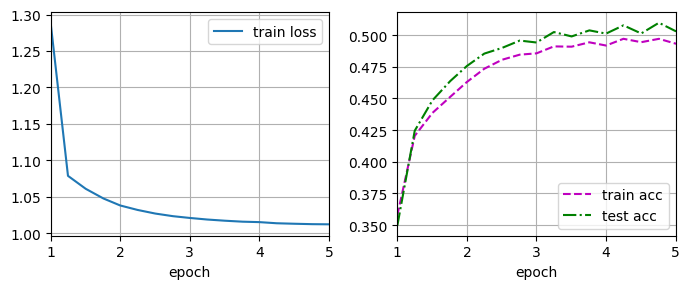

In [25]:
model = ch7.train_classifier(model, train_iter, test_iter, Epochs=5, lr=0.001, verbose=50)

**(B) 解冻 BERT，做第二轮微调**

现在我们观察到损失函数收敛了，说明下游任务网络的参数已经基本调优，但整体的准确率还是很低
* 这时候我们**解冻 BERT，用更小的学习率调整整个模型的参数**

In [26]:
# 冻结 BERT 的参数
model.bert_encoder.trainable = True
model.summary()

Model: "bert_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    multiple                  4385921   
                                                                 
 sequential (Sequential)     (None, 3)                 387       
                                                                 
Total params: 4,386,308
Trainable params: 4,386,307
Non-trainable params: 1
_________________________________________________________________


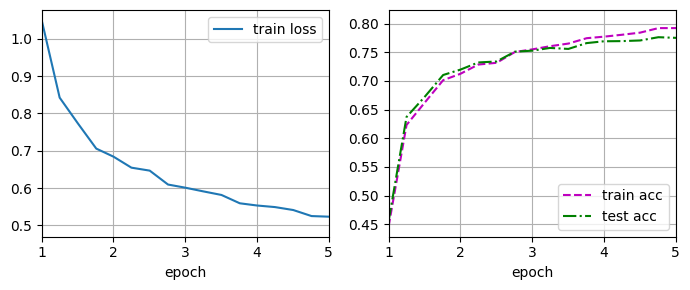

In [27]:
model = ch7.train_classifier(model, train_iter, test_iter, Epochs=5, lr=1e-4, verbose=50)

现在，我们测试模型的预测结果

In [29]:
def bert_predict_inference(model, train_set, premise : str, hypothesis : str):
    bert_input, _ = train_set.bert_input_preprocess([premise], [hypothesis], None)
    label = tf.argmax(model(bert_input), axis=1)[0]

    labels_dict = {0 : "entailment", 1 : "contradiction", 2 : "neutral"}
    return labels_dict[label.numpy()]

In [32]:
premise = "i see a black dog running in the park"
hypothesis = "the dog is black"
ch7.bert_predict_inference(model, train_set, premise, hypothesis)

'entailment'

----

### **练习**

----